### Assignment -- for the following image, use [histogram2d](https://docs.scipy.org/doc/numpy/reference/generated/numpy.histogram2d.html) to make a 2-dimensional histogram

Use the channel 1 reflectivity for your y-axis bins, and the channel 31 brightness temperature for your x-axis bins

In [1]:
from IPython.display import Image
from e582utils.data_read import download
from matplotlib import pyplot as plt
from mpl_toolkits.basemap import Basemap
from e582lib.radiation import planckInvert
import numpy as np
import matplotlib
import warnings

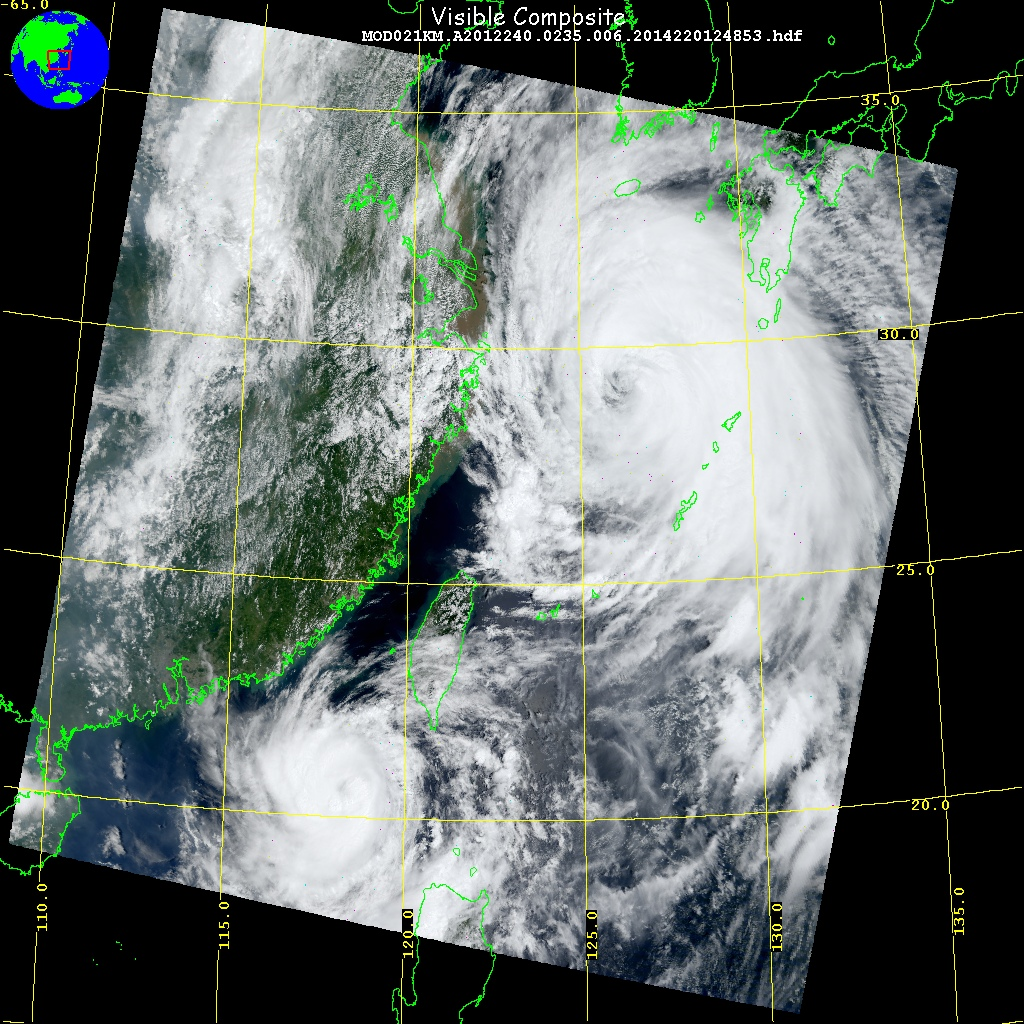

In [2]:
Image('MOBRGB.A2012240.0235.006.2015311151021.jpg',width=500)

In [3]:
l1b_file='MOD021KM.A2012240.0235.006.2014220124853.h5'
geom_file='MOD03.A2012240.0235.006.2012287184700.h5'
mask_file='MOD35_L2.A2012240.0235.006.2015059110241.h5'
cloud_file='MOD06_L2.A2012240.0235.006.2015062132158.h5'
files=[l1b_file,geom_file,mask_file,cloud_file]
for the_file in files:
    download(the_file)

trying https://clouds.eos.ubc.ca/~phil/courses/atsc301/downloads/MOD021KM.A2012240.0235.006.2014220124853.h5
writing to: MOD021KM.A2012240.0235.006.2014220124853.h5

MOD021KM.A2012240.0235.006.2014220124853.h5 already exists
and is 159169250 bytes
will not overwrite

trying https://clouds.eos.ubc.ca/~phil/courses/atsc301/downloads/MOD03.A2012240.0235.006.2012287184700.h5
writing to: MOD03.A2012240.0235.006.2012287184700.h5

MOD03.A2012240.0235.006.2012287184700.h5 already exists
and is 32287802 bytes
will not overwrite

trying https://clouds.eos.ubc.ca/~phil/courses/atsc301/downloads/MOD35_L2.A2012240.0235.006.2015059110241.h5
writing to: MOD35_L2.A2012240.0235.006.2015059110241.h5

MOD35_L2.A2012240.0235.006.2015059110241.h5 already exists
and is 12764605 bytes
will not overwrite

trying https://clouds.eos.ubc.ca/~phil/courses/atsc301/downloads/MOD06_L2.A2012240.0235.006.2015062132158.h5
writing to: MOD06_L2.A2012240.0235.006.2015062132158.h5

MOD06_L2.A2012240.0235.006.2015062132158.

In [4]:
from e582lib.modis_reproject import modisl1b_resample
chan_list=['1','31']
result_dict=\
       modisl1b_resample(l1b_file,geom_file,chan_list)

index and mean 0 0.3851117491722107
index and mean 1 5.329026222229004
running modisl1b_resample: here are the channels to be resampled
channel and mean 1 0.367159366607666
channel and mean 31 5.382923126220703
pyresample area_def information:

dump area definition:
Area ID: granule
Name: modis swath 5min granule
Projection ID: laea
Projection: {'datum': 'WGS84', 'lat_0': '26.23', 'lon_0': '122.97', 'proj': 'laea', 'units': 'm'}
Number of columns: 2119
Number of rows: 1827
Area extent: (-1463460.5703762136, -1149948.0434154244, 1292350.9187501024, 1225668.7002355251)


x and y pixel dimensions in meters:
1300.524534745784
1300.2828372473725

completed modisl1b_resample


In [5]:
result_dict['channels'].shape
result_dict['basemap_args']

{'ellps': 'WGS84',
 'lat_0': 26.231024420689351,
 'llcrnrlat': 15.20259069467446,
 'llcrnrlon': 109.36657049903813,
 'lon_0': 122.9693493168315,
 'projection': 'laea',
 'urcrnrlat': 36.5895404072976,
 'urcrnrlon': 137.42000586890035}

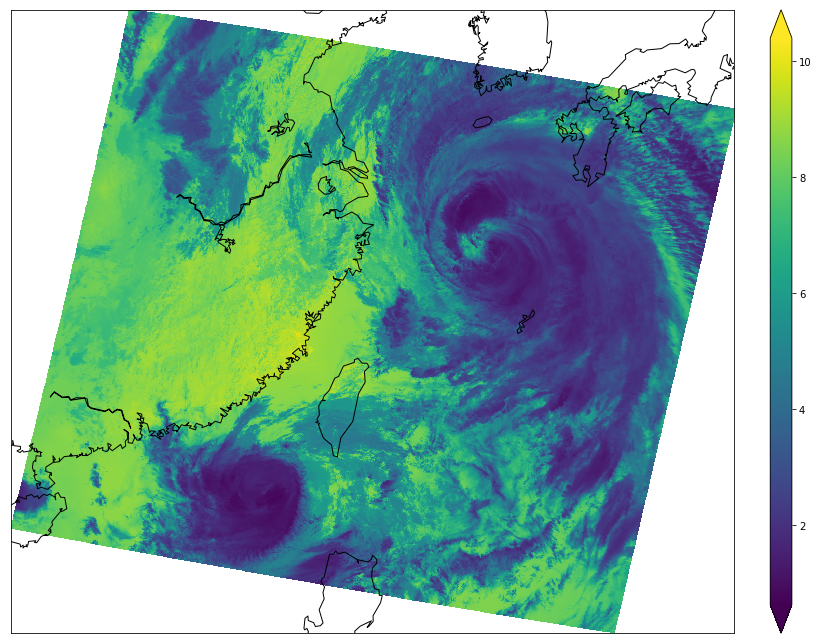

In [6]:
%matplotlib inline
fig,ax=plt.subplots(1,1,figsize=(14,14))
basemap_args=result_dict['basemap_args']
basemap_args['ax']=ax
basemap_args['resolution']='l'
bmap=Basemap(**result_dict['basemap_args'])
CS=bmap.imshow(result_dict['channels'][...,1],origin='upper')
CBar=bmap.colorbar(CS, 'right', size='3%', pad='5%',extend='both')
bmap.drawcoastlines()

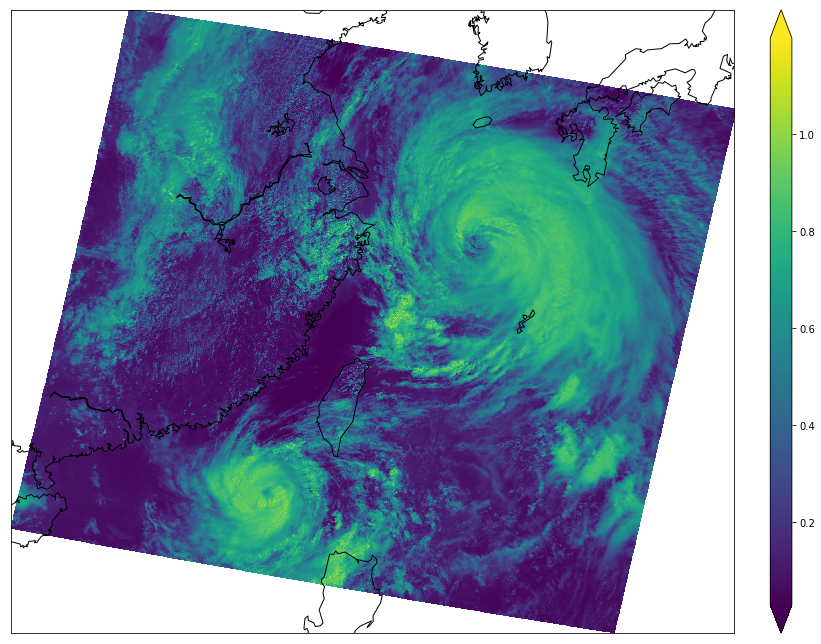

In [7]:
chan1=result_dict['channels'][...,0]
fig,ax=plt.subplots(1,1,figsize=(14,14))
basemap_args['ax']=ax
basemap_args['resolution']='l'
bmap=Basemap(**result_dict['basemap_args'])
CS=bmap.imshow(chan1,origin='upper')
CBar=bmap.colorbar(CS, 'right', size='3%', pad='5%',extend='both')
bmap.drawcoastlines();

In [8]:
wavel=11.e-6  #chan 31 central wavelength, meters
chan31_mks = result_dict['channels'][:,:,1]*1.e6  #W/m^2/m/sr
Tbright = planckInvert(wavel,chan31_mks)
Tbright = Tbright - 273.15 #convert to Centigrade

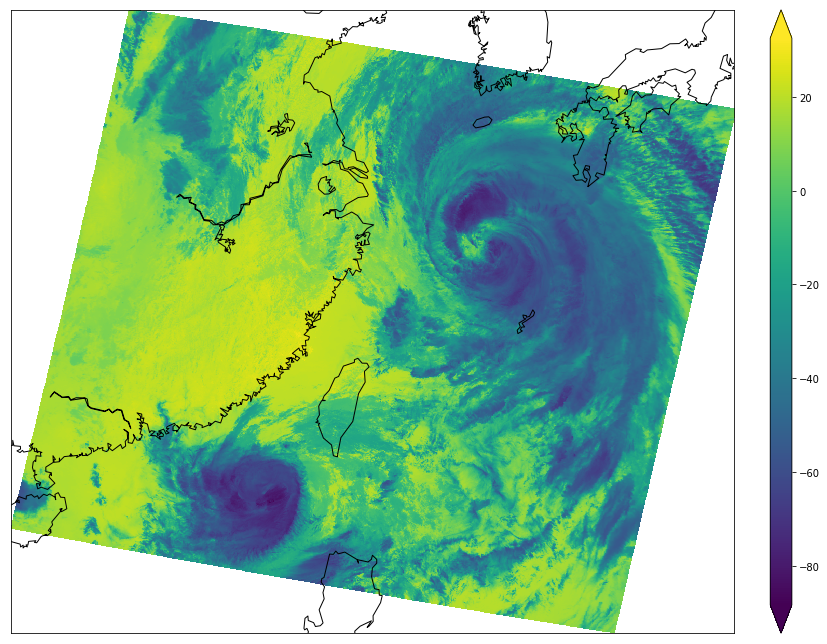

In [9]:
fig,ax=plt.subplots(1,1,figsize=(14,14))
basemap_args['ax']=ax
basemap_args['resolution']='l'
bmap=Basemap(**result_dict['basemap_args'])
CS=bmap.imshow(Tbright,origin='upper')
bmap.drawcoastlines();
CBar=bmap.colorbar(CS, 'right', size='3%', pad='5%',extend='both')

In [10]:
hit=np.logical_not(np.logical_or(np.isnan(chan1),np.isnan(Tbright)))

In [11]:
np.sum(hit)/Tbright.size
Tbright.shape
chan1.shape

(1827, 2119)

In [12]:
Tbright_bins=np.linspace(-80,30,100)
Tbright_bins.shape

(100,)

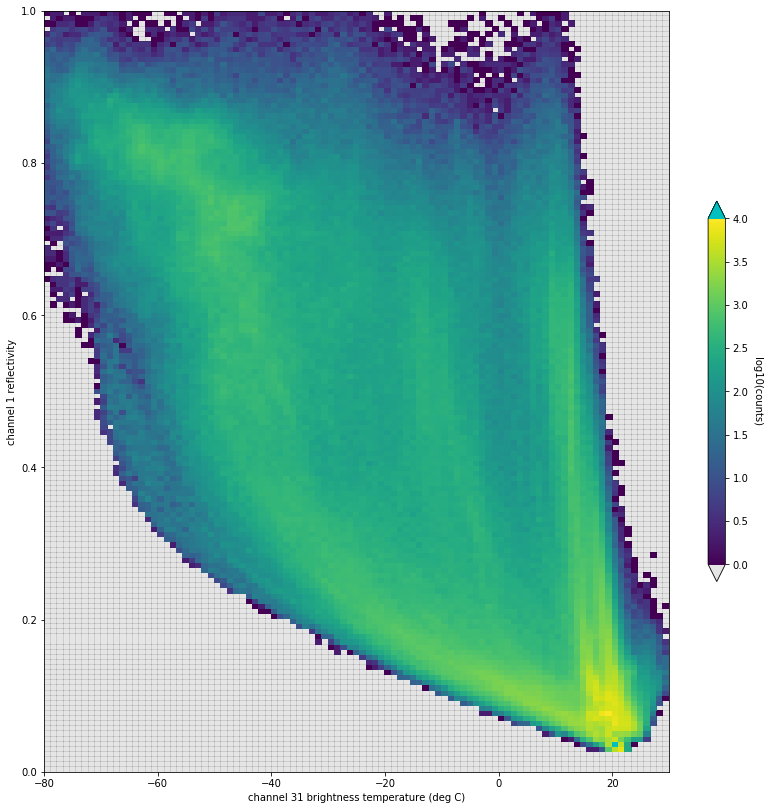

In [13]:
cmap=plt.cm.viridis
vmin=0
vmax=4
cmap.set_over('c')
cmap.set_under('k',alpha=0.1)
cmap.set_bad('k',alpha=0.1)
the_norm=matplotlib.colors.Normalize(vmin=vmin,vmax=vmax,clip=False)
Tbright_bins=np.linspace(-80,30,100)
refl_bins=np.linspace(0,1,150)
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    H,y_edges,x_edges=np.histogram2d(chan1.flat[:],Tbright.flat[:],bins=(refl_bins,Tbright_bins))
    Hmasked=np.ma.masked_invalid(H)
    fig,ax=plt.subplots(1,1,figsize=(14,14))
    CS=ax.pcolormesh(Tbright_bins,refl_bins,np.log10(Hmasked),cmap=cmap,norm=the_norm)
    ax.set(xlabel='channel 31 brightness temperature (deg C)',ylabel='channel 1 reflectivity')
    cax=fig.colorbar(CS, shrink=0.5, pad=0.05,extend='both')
    out=cax.ax.set_ylabel('log10(counts)')
    out.set_rotation(270)
    out.set_verticalalignment('bottom'); 